<a href="https://colab.research.google.com/github/christmasv/Proyectos-de-ML/blob/Clasificacion-Aprendizaje-Supervisado/Reating_crediticio_modelo_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de Incumplimiento de Préstamos: Construyendo un Modelo ML para la Evaluación del Riesgo del Solicitante!**


#


 **Author** = [Christopher Soto](https://twitter.com/csv_81)

    @article{khrizoto,     
    Title        = {Predicción de Incumplimiento de Préstamos},
    Howpublished = {\url{https://khrizoto.wordpress.com/}},
    Year         = {2024}
    

**Descripción:**

En el mundo financiero, la concesión de préstamos es una práctica común que implica un cierto grado de riesgo para las instituciones crediticias. Una de las preocupaciones principales para estas instituciones es la posibilidad de que los solicitantes de préstamos no cumplan con sus obligaciones financieras, lo que puede resultar en pérdidas significativas. Identificar de manera precisa y oportuna a los solicitantes con mayor riesgo de incumplimiento es fundamental para mitigar estos riesgos y mantener la estabilidad financiera.

En este contexto, el uso de técnicas avanzadas de aprendizaje automático se ha vuelto indispensable. Estas técnicas permiten analizar grandes volúmenes de datos para identificar patrones y correlaciones que pueden predecir el riesgo de incumplimiento de un préstamo. Este proyecto se centra en la construcción de un modelo de aprendizaje automático diseñado específicamente para predecir si un solicitante de préstamo tiene una alta probabilidad de no devolver el préstamo. Al hacerlo, se busca proporcionar a las instituciones financieras una herramienta eficaz para evaluar el riesgo crediticio y tomar decisiones informadas al otorgar préstamos.

# Acerca del conjunto de datos
# **Contexto**
La base de datos fue creada con registros de ausentismo laboral de julio de 2007 a julio de 2010 en una empresa de mensajería en Brasil.

* Número de instancias: 700
* Número de atributos: 11
* Valores faltantes: 0

**Fuentes Datos**: https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

In [2]:
# Instalar paquetes necesarios <--
# !pip install pygam
# !pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.9 MB/s eta 0:00:00


In [6]:
!pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 22.3 MB/s eta 0:00:00


In [7]:
#importacion de librerias Necesarias
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


Colab environment detected.


In [56]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / ''

In [57]:
# Definir rutas a conjuntos de datos.

LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'


In [58]:
!ls /content/

full_train_set.csv     loan3000.csv   loan_data.csv.gz	sample_data
full_train_set.csv.gz  loan_data.csv  Proyectos-de-ML


In [36]:
!git clone https://github.com/christmasv/Proyectos-de-ML.git

Cloning into 'Proyectos-de-ML'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 11), reused 20 (delta 2), pack-reused 0
Receiving objects: 100% (34/34), 9.34 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [59]:
loan_data = pd.read_csv(LOAN_DATA_CSV)


# Analisis Exploratorio de los Datos

In [61]:
loan_data.describe()

,Unnamed: 0,loan_amnt,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,emp_length,borrower_score
count,45342.00000,45342.000000,4.534200e+04,45342.000000,45342.000000,4.534200e+04,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000
mean,22671.50000,13154.814521,6.821170e+04,16.133731,8.032225,1.485745e+04,56.051800,0.857527,0.912090,10.413105,4.599087,6.321115,0.499006
std,13089.25229,8088.533525,5.623902e+04,7.594881,4.264034,2.008254e+04,25.430276,0.349538,0.283167,4.696616,1.479069,3.752789,0.128687
min,1.00000,500.000000,2.000000e+03,0.000000,0.048892,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.050000
25%,11336.25000,7000.000000,4.200000e+04,10.460000,4.671572,5.657000e+03,37.900000,1.000000,1.000000,7.000000,3.600000,3.000000,0.400000
50%,22671.50000,11500.000000,6.000000e+04,16.020000,7.499355,1.076550e+04,58.400000,1.000000,1.000000,10.000000,4.800000,6.000000,0.500000
75%,34006.75000,18000.000000,8.100000e+04,21.590000,10.940575,1.861350e+04,76.400000,1.000000,1.000000,13.000000,5.800000,11.000000,0.600000
max,45342.00000,35000.000000,7.141778e+06,38.860000,43.545600,1.743266e+06,128.100000,1.000000,1.000000,76.000000,7.000000,11.000000,1.000000


In [66]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Unnamed: 0         45342 non-null  int64   
 1   status             45342 non-null  object  
 2   loan_amnt          45342 non-null  int64   
 3   term               45342 non-null  object  
 4   annual_inc         45342 non-null  int64   
 5   dti                45342 non-null  float64 
 6   payment_inc_ratio  45342 non-null  float64 
 7   revol_bal          45342 non-null  int64   
 8   revol_util         45342 non-null  float64 
 9   purpose            45342 non-null  object  
 10  home_ownership     45342 non-null  object  
 11  delinq_2yrs_zero   45342 non-null  int64   
 12  pub_rec_zero       45342 non-null  int64   
 13  open_acc           45342 non-null  int64   
 14  grade              45342 non-null  float64 
 15  outcome            45342 non-null  category
 16  emp_

In [68]:
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [80]:
loan_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [81]:
categorical_atts = ['status','term','purpose','home_ownership','outcome','purpose_','home_','emp_len_']
numerical_atts = loan_data.drop(columns=categorical_atts).columns.to_list()


In [82]:
# número de valores únicos en atributos categóricos
loan_data[categorical_atts].nunique()

status             3
term               2
purpose           12
home_ownership     4
outcome            2
purpose_           7
home_              3
emp_len_           2
dtype: int64

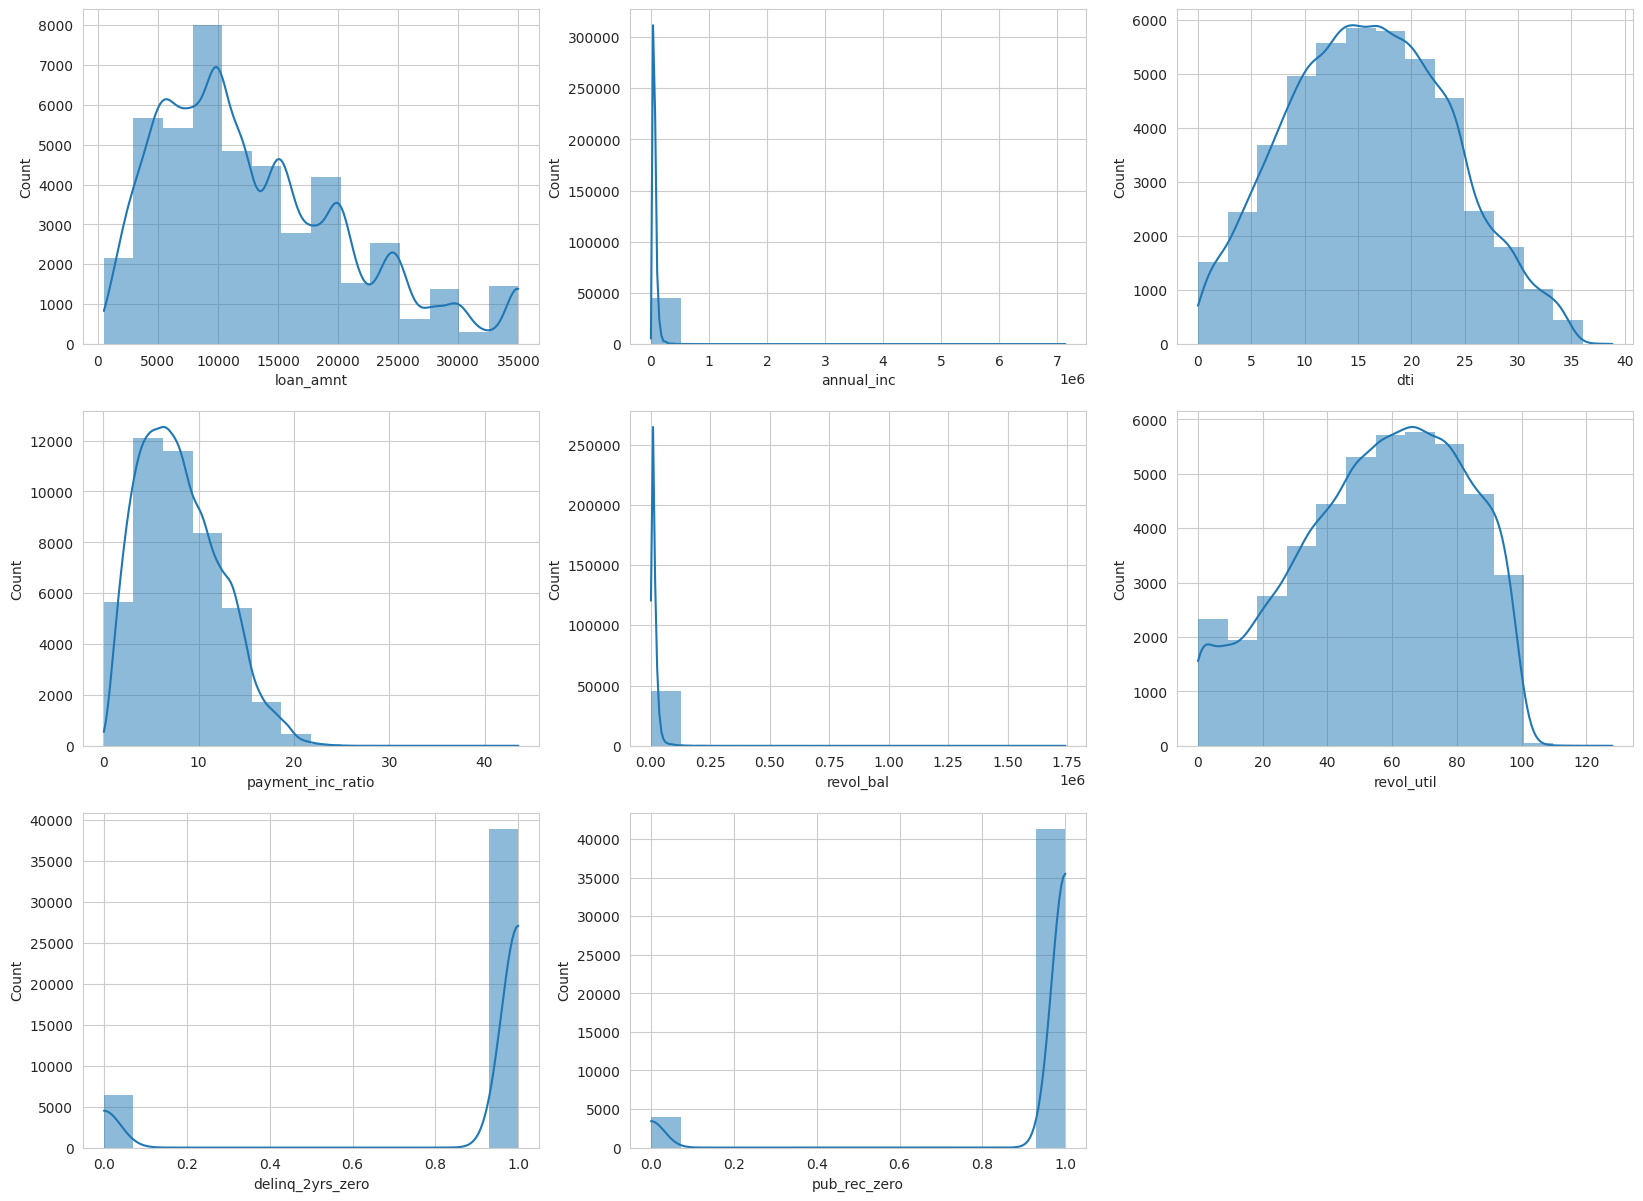

In [83]:
# graficamos la distribucion de las variables numericas
num_df = loan_data[numerical_atts]
plt.figure(figsize=(20,20))
for i in range(1, 9):
    plt.subplot(4, 3, i)
    sns.histplot(num_df[num_df.columns[i-1]],bins=14, kde=True, linewidth=0)

<ipython-input-84-ed342eceebb1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=loan_data, x='outcome', kind= 'count', height=4, aspect=4, palette='muted')


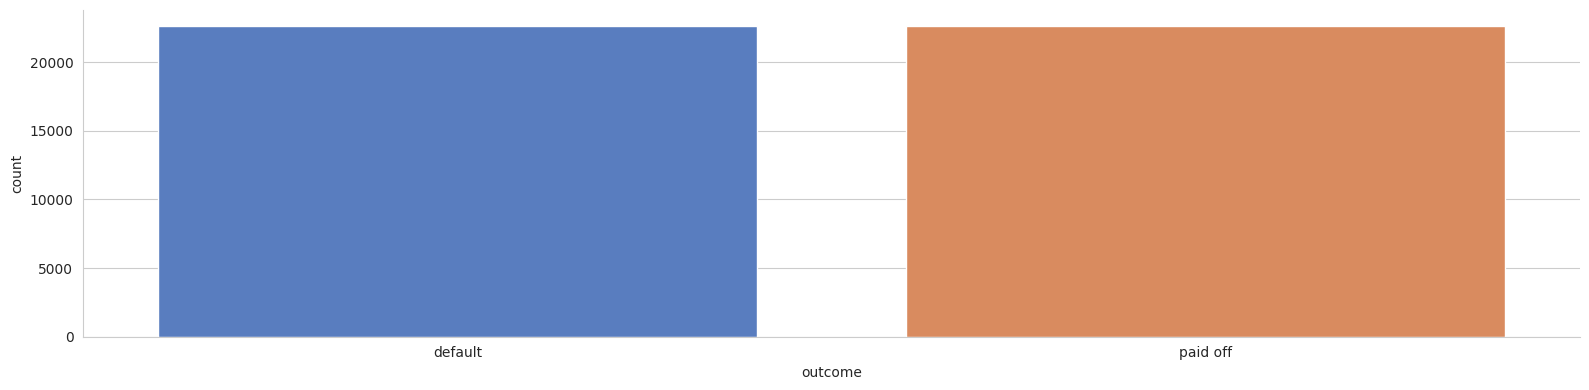

In [84]:
# graficamos como esta distribuida la variable "outcome"
sns.set_style("whitegrid")
sns.catplot(data=loan_data, x='outcome', kind= 'count', height=4, aspect=4, palette='muted')

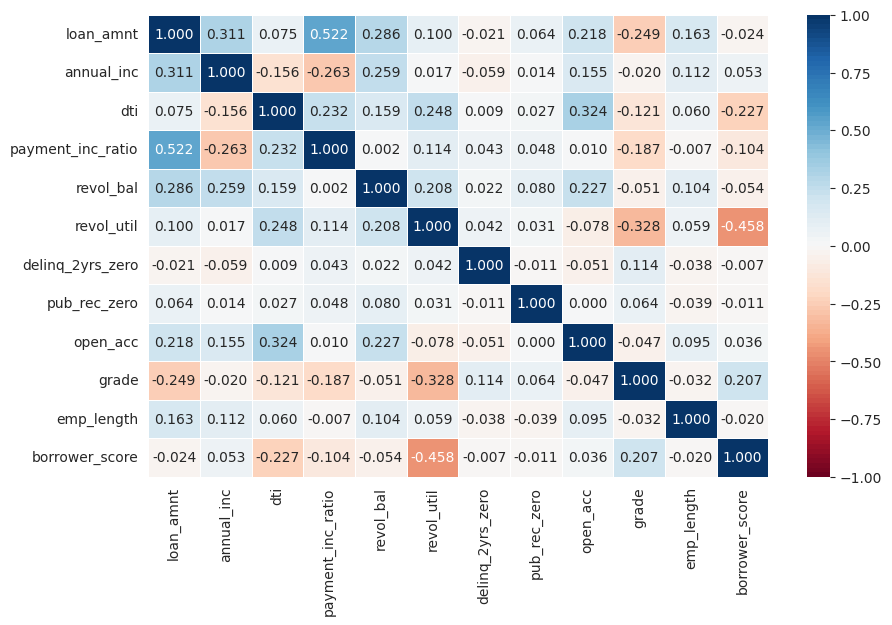

In [85]:
# creamos la matríz de correlación
num_corr = num_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(num_corr, annot=True, fmt=".3f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("RdBu", 100))
plt.yticks(rotation=0)
plt.show()

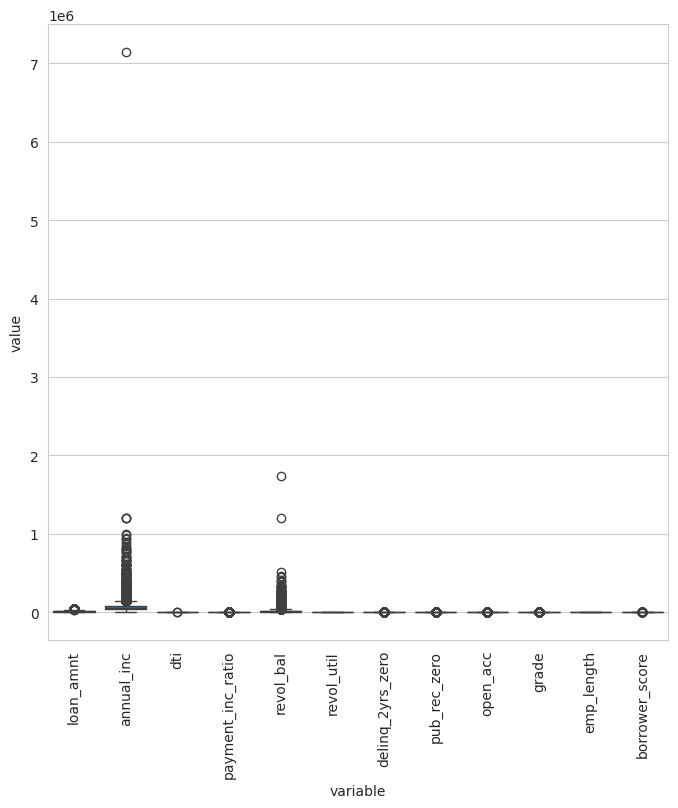

In [86]:
# Graficamos boxplots para resumir la distribución de datos cuantitativos, esto nos permite identificar rápidamente la mediana, los cuartiles, la asimetría y la presencia de valores atípicos en un conjunto de datos
plt.figure(figsize=(8,8))
sns.boxplot(x="variable", y="value", data=pd.melt(num_df))
plt.xticks(rotation=90)
plt.show()


# Preprocesamiento del dataset

In [64]:
# Dividimos la variales numericas y categoricas
# convertir a variables categoricas
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

In [ ]:


X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

# Modelo de Machine Learning

Se probará un modelo de regresión logística para clasificar a las personas en 2 clases:
* personas con excesiva ausencia laboral
* personas con moderada ausencia laboral.

La media de las horas de ausencia laboral es 3. Se plantea la siguiente hipótesis: ¿Cómo definimos las clases? Moderada ausencia si las horas son menores o iguales a 3 y excesivas si son mayores a 4 horas.

Lo que se hace ahora es cambiar las horas 1,2,3 por la clase 0 (Moderada) y 4,5,6,7,8… por la clase 1 (Excesivo). Para esto se usara la función where de python.

# Modelo de Regresión Logistica

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
reg = LogisticRegression()
reg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
reg.score(X_train, y_train)

0.7714285714285715

In [ ]:
reg.score(X_test, y_test)

0.7642857142857142

In [ ]:
#Guardar Modelo
import pickle
with open('model', 'wb') as file:
    pickle.dump(reg,file)

In [ ]:
salida = reg.predict(X_train)

In [ ]:
salida

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,

In [ ]:
salida == y_train

array([ True,  True, False,  True,  True,  True, False,  True, False,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,

In [ ]:
np.sum(salida==y_train)/salida.shape[0]

0.7714285714285715

In [ ]:
#Calculando coefiecientes e interseccion
reg.intercept_

array([-1.66303089])

In [ ]:
reg.coef_

array([[ 2.74161885,  0.65121574,  2.95142135,  0.94241366,  0.61287662,
         0.01490627, -0.17095496,  0.00376671,  0.23458944,  0.02841559,
         0.38638828, -0.34432549,  0.07305004, -0.21934319]])

In [ ]:
feature_name = inputs.columns.values

In [ ]:


summary_table = pd.DataFrame(columns=['Caracteristica'], data = feature_name)
summary_table['Coeficiente'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Interseccion', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table['Odds_ratio'] = np.exp(summary_table.Coeficiente)
summary_table



,Caracteristica,Coeficiente,Odds_ratio
0,Interseccion,-1.663031,0.189564
1,Reason_1,2.741619,15.512077
2,Reason_2,0.651216,1.917871
3,Reason_3,2.951421,19.133129
4,Reason_4,0.942414,2.566168
5,Transportation Expense,0.612877,1.845733
6,Distance to Work,0.014906,1.015018
7,Age,-0.170955,0.842860
8,Daily Work Load Average,0.003767,1.003774
9,Body Mass Index,0.234589,1.264390


El entrenamiento y la puntuación de un modelo de regresión logística proporcionan una comprensión vital sobre la importancia de cada característica en la predicción del resultado. Los coeficientes más grandes indican una mayor influencia de esa característica en el resultado. Por otro lado, los coeficientes más pequeños indican una influencia menor.

En nuestro caso, las características están estandarizadas, lo que significa que tienen la misma escala, lo que nos permite comparar su importancia directamente. Cuando aplicamos la regresión logística, obtenemos el logaritmo de las odds (oportunidades) como resultado. La transformación logarítmica nos permite clasificar el resultado en 0 o 1.

El valor de odds_ratio proporciona una perspectiva importante: por ejemplo, para la razón 3, que tiene un odds_ratio mayor, indica que una persona con esta razón tiene aproximadamente 18 veces más probabilidades de estar excesivamente ausente que una persona que no presenta esta razón. Este análisis resume de manera efectiva cómo cada característica afecta las probabilidades de que ocurra el evento de interés.

In [ ]:
summary_table.sort_values('Odds_ratio', ascending=False)

,Caracteristica,Coeficiente,Odds_ratio
3,Reason_3,2.951421,19.133129
1,Reason_1,2.741619,15.512077
4,Reason_4,0.942414,2.566168
2,Reason_2,0.651216,1.917871
5,Transportation Expense,0.612877,1.845733
11,Children,0.386388,1.471656
9,Body Mass Index,0.234589,1.264390
13,Month Value,0.073050,1.075784
10,Education,0.028416,1.028823
6,Distance to Work,0.014906,1.015018


Se puede concluir que la razón con el mayor coeficiente y, por ende, el mayor impacto en la ausencia laboral es la Razón 3, que abarca síntomas graves poco comunes y envenenamiento. Este resultado tiene sentido, ya que es comprensible que alguien no asista al trabajo de inmediato en tales circunstancias.

La segunda razón con mayor impacto es la Razón 1, relacionada con problemas circulatorios, respiratorios, digestivos, entre otros. Es comprensible que alguien falte al trabajo debido a malestares estomacales, dolor abdominal, náuseas, etc. Una persona con esta razón tiene aproximadamente 14 veces más probabilidades de ausentarse excesivamente que alguien sin esta razón.

La Razón 2 está relacionada con embarazo y fiestas de cumpleaños. Es lógico que esta razón tenga una baja probabilidad de ausencia excesiva, ya que los días de licencia por embarazo suelen ser limitados, y las fiestas de cumpleaños de los hijos no ocupan mucho tiempo en el año.

El costo del transporte es la variable más relevante entre las no categóricas, aunque al estar estandarizada, su interpretación directa en términos de odds es limitada.

Los modelos estandarizados son preferidos por ingenieros en machine learning cuando se busca una alta precisión, ya que el algoritmo tiende a funcionar mejor con datos estandarizados. Sin embargo, los economistas y estadistas suelen priorizar la interpretación de variables sobre la precisión. Los científicos de datos se encuentran en un punto intermedio, ya que a veces necesitan alta precisión y otras veces valoran otras consideraciones.







# Guardar el Modelo y Deploy

In [ ]:
import pickle

#Guardando el modelo
with open('model', 'wb') as file:
    pickle.dump(reg, file)

#Guardando la data estandarizada
with open('scaler', 'wb') as file:
    pickle.dump(escalado, file)
